# *Imports*

In [ ]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(26)
np.random.seed(26)

from functions import *

---------------

# **Part 1 of the homework**

## Optimization via Gradient Descent (GD)

Given a set of *admissible solutions* $\Omega \subseteq \mathbb{R}^n$, an optimization problem is a problem of the form

$$
x^* = \arg\min_{x \in \mathbb{R}^n}f(x).
$$

If $\Omega = \mathbb{R}^n$, we say that the optimization is **unconstrained**. If $\Omega \subset \mathbb{R}^n$, the problem is **constrained**. In the following, we will always assume $\Omega = \mathbb{R}^n$, i.e. the unconstrained setup.

GD is an algorithm that iteratively updates the estimate of the solution, defined as:

$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k), \quad k = 0, 1, \dots, \texttt{maxit}
$$

where the initial iterate, $x_0 \in \mathbb{R}^n$, is given as input and the **step-size** (equivalently, **learning rate**) $\alpha_k > 0$ controls the decay rapidity of $f(x)$ for any $k \in \mathbb{N}$.

To assure convergence to a stationary point. Since for GD, $p_k = - \nabla f(x_k)$, then the condition above is always satisfied:

$$
\nabla f(x_k)^T p_k = - \nabla f(x_k)^T \nabla f(x_k) = - || \nabla f(x_k) ||_2^2 \leq 0.
$$

Therefore, GD algorithm **always** converge to a stationary point in the limit of infinite iterations.

## Parameters

### Step Size
Selecting the step.  
There are three possible scenario that happens in selecting the step size:

* $\alpha_k$ is too small $\implies$ we never get to the minimum, getting closer and closer without reaching it. Moreover, we can easily get stuck on local minima when the _objective function_ is non convex. 
* $\alpha_k$ is too large $\implies$ we get stuck, bouncing back and forth around the minima.
* $\alpha_k$ is correct $\implies$ we reach the stationary point.


### Backtracking
Fortunately, there is a way to guarantee that the chosen step-size $\alpha_k$ is correct. Indeed, it is possible to prove that, if $\alpha_k$ satisfies the following conditions (known as **Wolfe Conditions**):

- *Sufficient decrease:* $ f(x_k - \alpha_k \nabla f(x_k)) \leq f(x_k) - c_1 \alpha_k || \nabla f(x_k) ||_2^2 $;
- *Curvature condition:* $\nabla f(x_k)^T \nabla f(x_k - \alpha_k \nabla f(x_k)) \leq c_2 ||  \nabla f(x_k)  ||_2^2$;

### Stopping criteria
**Stopping criteria 1:** Given a tollerance `tol_f`, for any iterate $x_k$, check whether or not $|| \nabla f(x_k) || \leq tol_f || \nabla f(x_0) ||$. If so, stop the iterations.

Unfortunately, this condition alone is not sufficient. Indeed, if the function $f(x)$ is almost flat around its minimum, then $|| \nabla f(x_k) ||$ will be small even if $x_k$ will be far from the true minimum. 


Consequently, its required to add another stopping criteria.

**Stopping criteria 2:** Given a tollerance `tol_x`, for any iterate $x_k$, check whether or not $|| x_k - x_{k-1} || \leq tol_x$. If so, stop the iterations


In [ ]:
def backtracking(x, f, grad_f, params_f = None):
    """
    Backtracking method to find the best alpha that satisfies the backtracking condition.

    inputs:
    x: ndarray. The actual iterate x_k.
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    params_f: tuple. Tuple with the parameters of f.

    outputs:
    alpha: float. The value of alpha that satisfies the backtracking condition.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    # Calculating the gradient of f(x)
    grad_f_x = grad_f(x, params_f)
    # Calculating f(x)
    f_x = f(x, params_f)

    n = 0
    
    if grad_f_x.shape != (1,1):
        n = norm(grad_f_x,2)
    else:
        n = np.abs(grad_f_x)

    # Cheking the Sufficent Decrease Condition (Armijo Condition)
    # f(x - alpha*grad_f_x) <= f(x) - c*alpha*(grad_f_x^T)*grad_f_x
    # second Wolf condition (Curvature condition) is automatically satisfied
    while f((x - (alpha * grad_f_x).T).flatten(), params_f) > f_x - c * alpha * (n ** 2):
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def GD(f, grad_f, params_f = None, x0=0, maxit=1000, back_flag=False, alpha=0.1, tolf=1e-5, tolx=1e-5):
    """
    Gradient Descent method

    inputs:
    f: function. Function to be minimized(optimize).
    grad_f: function. Gradient of f.
    params_f: tuple. Tuple with the parameters of f.
    x0: ndarray. Initial guess of theta to start and optimize.
    maxit: int. Maximum number of iterations.
    tolf: float. Tolerance for the of the algorithm. Convergence is reached when the norm(grad_f(x_k),2) < tolf*norm(grad_f(x0),2).
    tolx: float. Tolerance for the x value. Convergence is reached when norm(x_k - x_k-1,2) < tolx.
    back_flag: bool. If True, the algorithm uses backtracking to update alpha.
    alpha: float. Value of alpha. Only used if back_flag is False.

    outputs:
    x: ndarray. (Hystory) Array that contains the value of x(theta) for each iterate.
    k: int. Number of iterations needed to converge.
    f_val: ndarray. (Hystory) Array of the value of each f(x).
    grads: ndarray. (Hystory) Array of gradient values.
    err: ndarray. (Hystory) Array of error values (normalize gradient).
    converge: bool. True if the method converges.
    message: str. Message that explains why the method stopped.
    """
    # Trashold to check if the values are diverging
    div_chek = 1e10

    # Calculate the initial alpha value
    if back_flag:
        alpha = backtracking(x0, f, grad_f, params_f)

    # Setting the initial values
    x, f_val, grads, err = [], [], [], []
    x.append(x0)
    f_val.append(f(x0, params_f))
    grads.append(grad_f(x0, params_f))
    err.append(norm(grads[0],2))

    for k in range(1,maxit):
        # Update the x value iterativly and saves the last value
        x_k = x[k-1] - (alpha*grad_f(x[k-1], params_f).flatten())
        x.append(x_k)
        if (x[k] > div_chek).any():
            message = "Diverging 1"
            # print(message)
            return x,k,f_val,grads,err,False,message
        
        # Update alpha with backtracking
        if back_flag:
            alpha = backtracking(x[k], f, grad_f, params_f)
        
        # Adding the values to be returned
        f_val.append(f(x[k], params_f))
        grads.append(grad_f(x[k], params_f))
        err.append(norm(grads[k],2))
        
        if (grads[k] > div_chek).any():
            message = "Diverging 2"
            # print(message)
            return x,k,f_val,grads,err,False,message
        

        # Check the stop condition
        if norm(grad_f(x[k], params_f),2) < tolf * norm(grad_f(x0, params_f),2):
            message = "Stop for f tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        if norm(x[k] - x[k-1],2) < tolx:
            message = "Stop for x tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        
    message = "Reached maxit"
    # print(message)
    return x,maxit,f_val,grads,err,True,message


### **FUNCTION 1**

$f : R^2 → R$ such that

$$f (x_1, x_2) = (x_1 − 3)^2 + (x_2 − 1)^2$$
for which the true optimum is $x^* = (3, 1)^T$ .

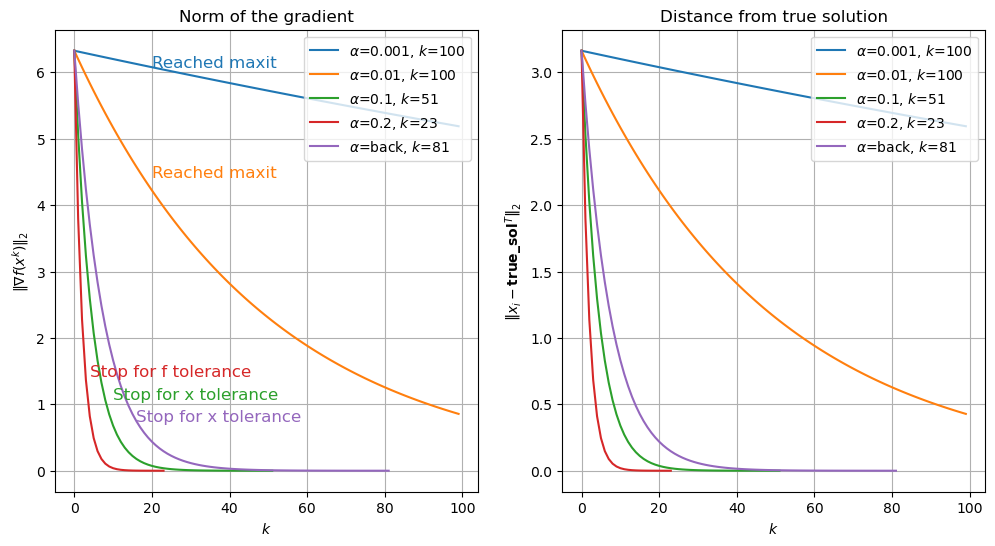

In [2]:

def f_1(x, ignore):
    return (x[0] - 3)**2 + (x[1] - 1)**2

def grad_f1(x, ignore):
    x = x.flatten()
    return np.array([[2*(x[0] - 3)],
                     [2*(x[1] - 1)]])

true_sol = np.array([[3],[1]])
x0 = np.array([0,0])
exercise_GD(f_1,grad_f1,x0=x0,true_sol=true_sol) 

For $\alpha<0.01$, the gradient descent speed appears to be logaritmic, and a solution is found after a $K = 80$ iterations. This suggests that smaller learning rates ensure convergence but at the cost of slower progress. The stability observed here could be due to the small step size, which avoids overshooting the optimal solution.

### **Function 2**

$f : \mathbb{R}^2 → \mathbb{R}$ such that:

$$f (x_1, x_2) = 10(x_1 − 1)^2 + (x_2 − 2)^2$$

for which the true optimum is $x^∗ = (1, 2)^T$.

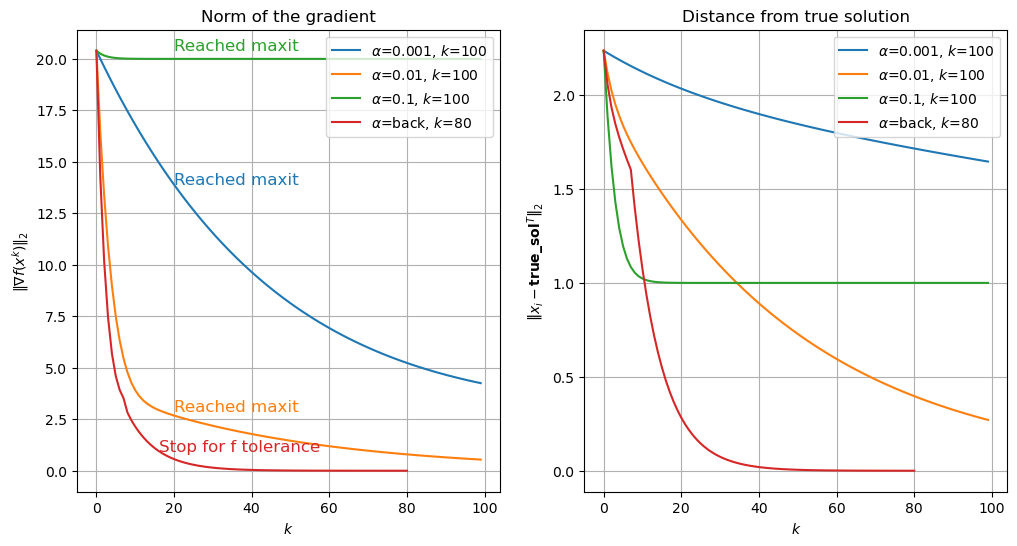

In [3]:
def f2(x, ignore):
    return 10*(x[0] - 1)**2 + (x[1] - 2)**2

def grad_f2(x, ignore):
    x = x.flatten()
    return np.array([[20*(x[0] - 1)],
                     [2*(x[1] - 2)]])

true_sol = np.array([[1],[2]])
x0 = np.array([0,0])
exercise_GD(f2,grad_f2,x0=x0,true_sol=true_sol)

In this case, despite varying values of $\alpha$, if *backpropagation* is not used to find an optimal $\alpha$, we will never reach the true solution. However, convergence might still occur for $K_{max}>100$ and for $\alpha<0.01$.  

### **Function 3**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2$$

where $A \in \mathbb{R}^{n \times n}$ is the Vandermonde matrix associated with the vector $v \in \mathbb{R}^n$ that contains $n$ equispaced values in the interval $[0, 1]$, and $b \in \mathbb{R}^n$ is computed by first setting $x_{true} =
(1, 1, \dots , 1)^T$ and then $b = A x_{true}$. Try for different values of $n$ (e.g. $n = 5, 10, 15, \dots$ ).

n =  5


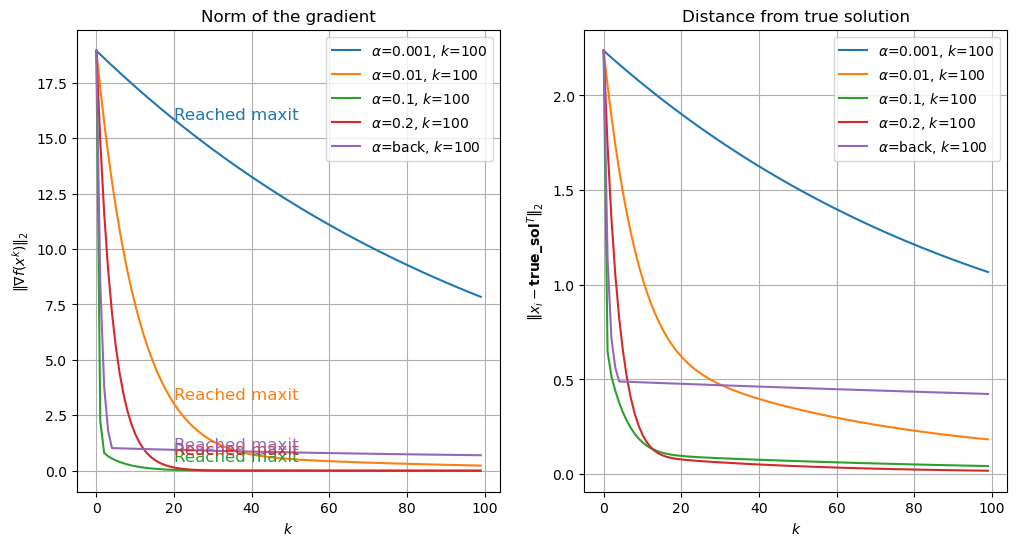

n =  10


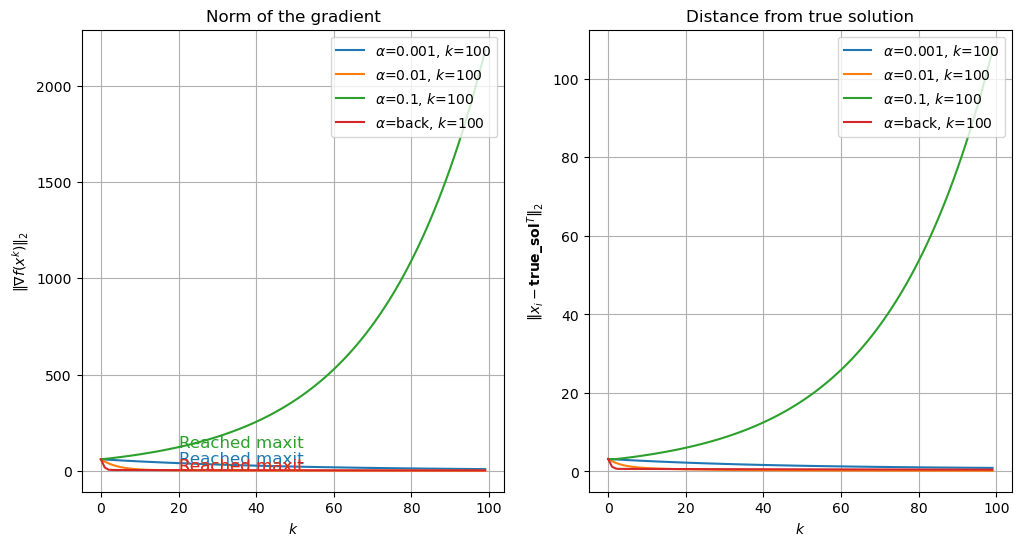

n =  20


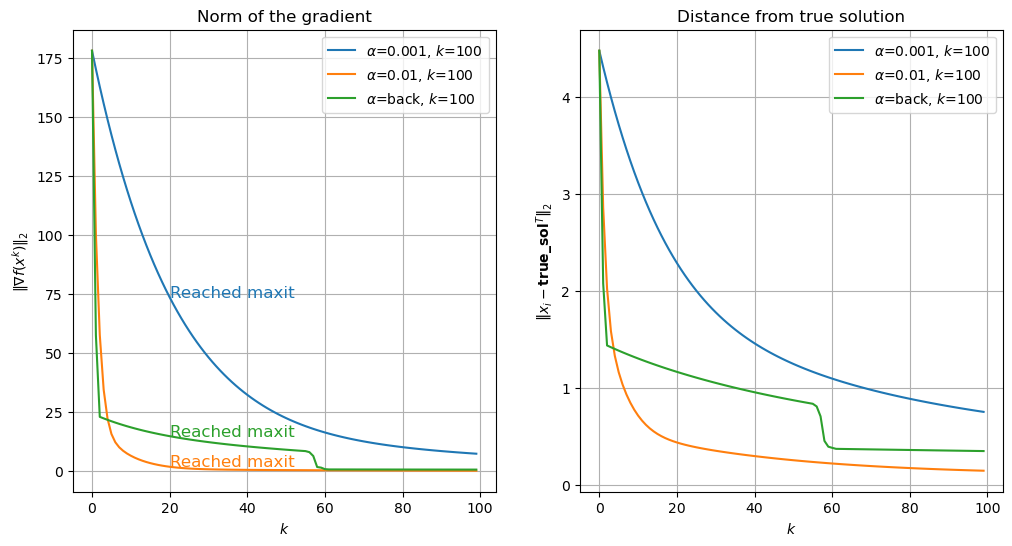

n =  50


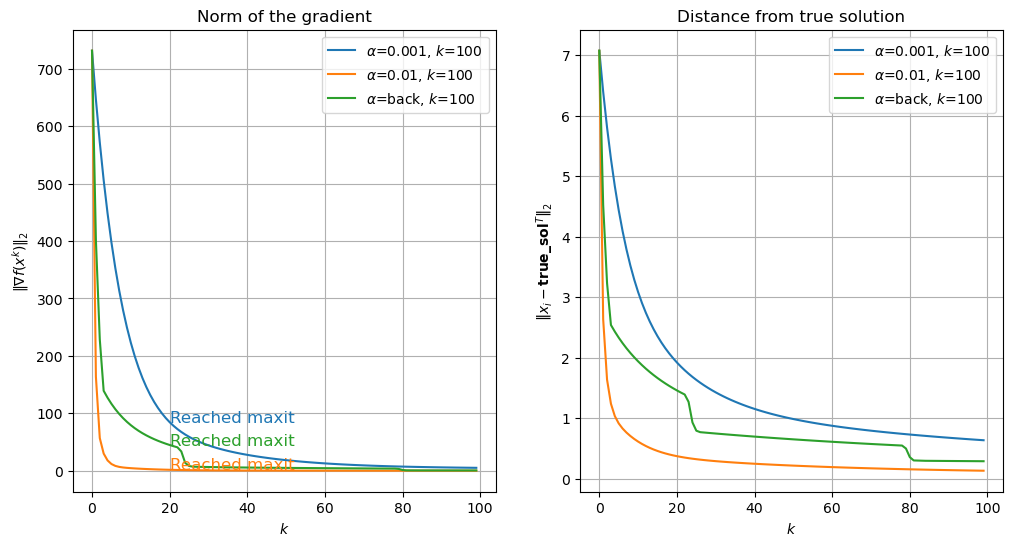

n =  100


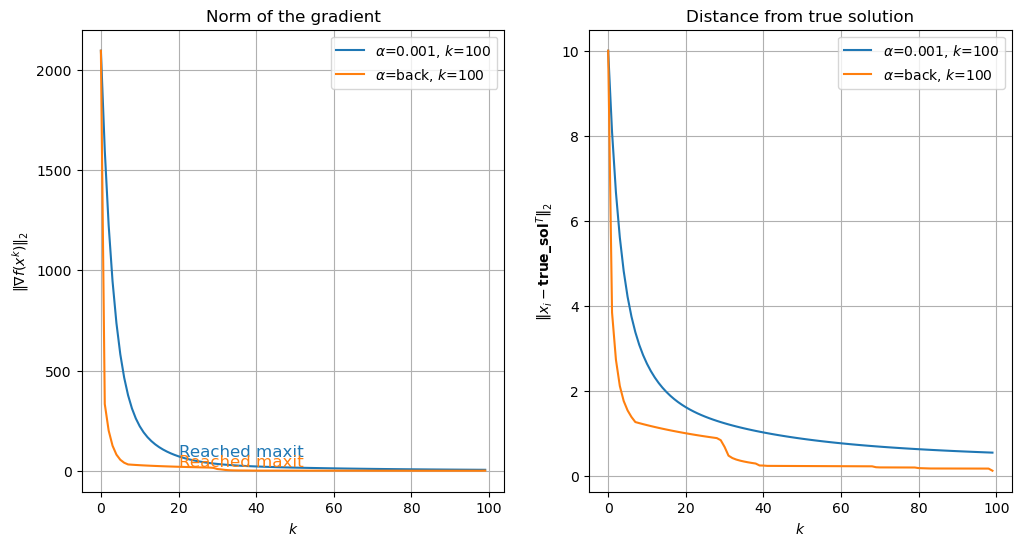

In [4]:
for n in [5,10,20,50,100]:
    print("n = ",n)
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true

    def f3(x,ignore):
        return (norm(A @ x - b,2) ** 2)/2

    def grad_f3(x,ignore):
        M = A @ x - b.T
        return (M @ A).T

    x0 = np.zeros((n,))
    exercise_GD(f3,grad_f3,x0=x0,true_sol=x_true,dimensions=n)

In the case of the Vandermonde matrix, we observe that for small dimensions, convergence is almost always achieved. However, for dimensions greater than 10, convergence occurs only for consecutively smaller values of $\alpha$, while the remaining cases fail to converge.  
This behavior can be attributed to the ill-conditioning of the Vandermonde matrix, which becomes more pronounced as the dimensionality increases. When backpropagation or adaptive optimization methods are used, this issue does not occur, suggesting that such methods can better handle numerical instability and conditioning problems.

### **Function 4**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2 + \frac{\lambda}{2} \lVert x \rVert _2^2$$

where $A$ and $b$ are the same of the exercise above, while $\lambda$ is a fixed value in the interval $[0, 1]$.
Try different values for $\lambda$.

lam =  0


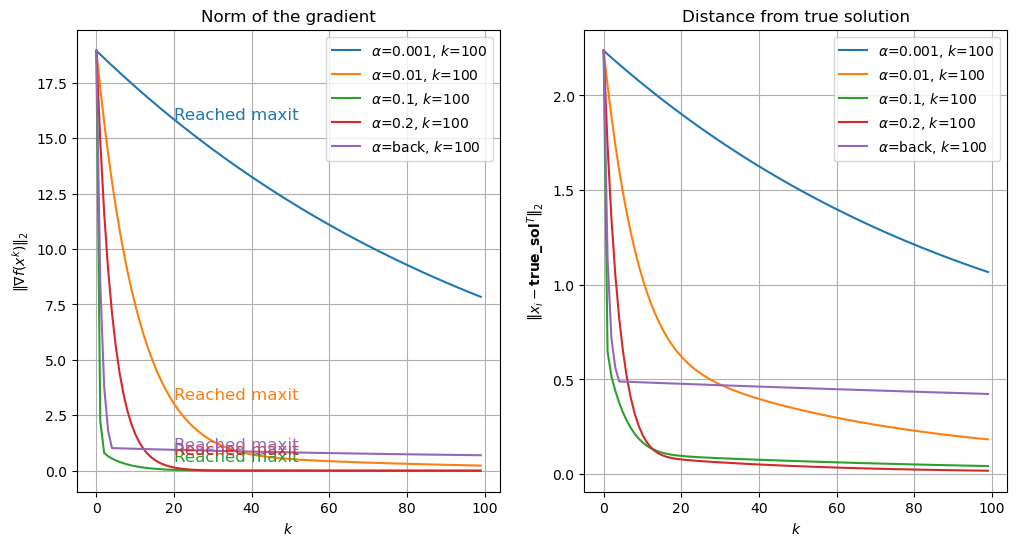

lam =  0.1


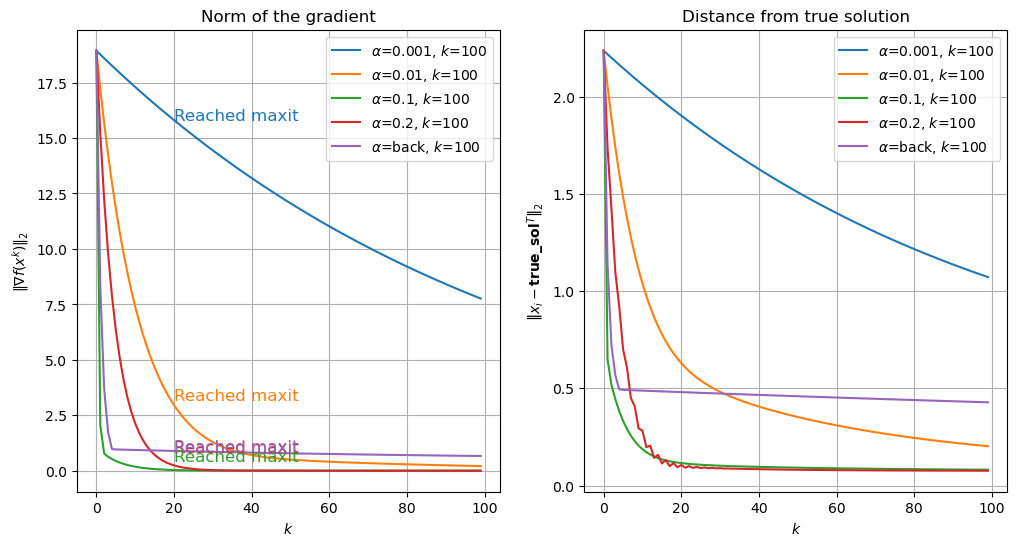

lam =  0.4


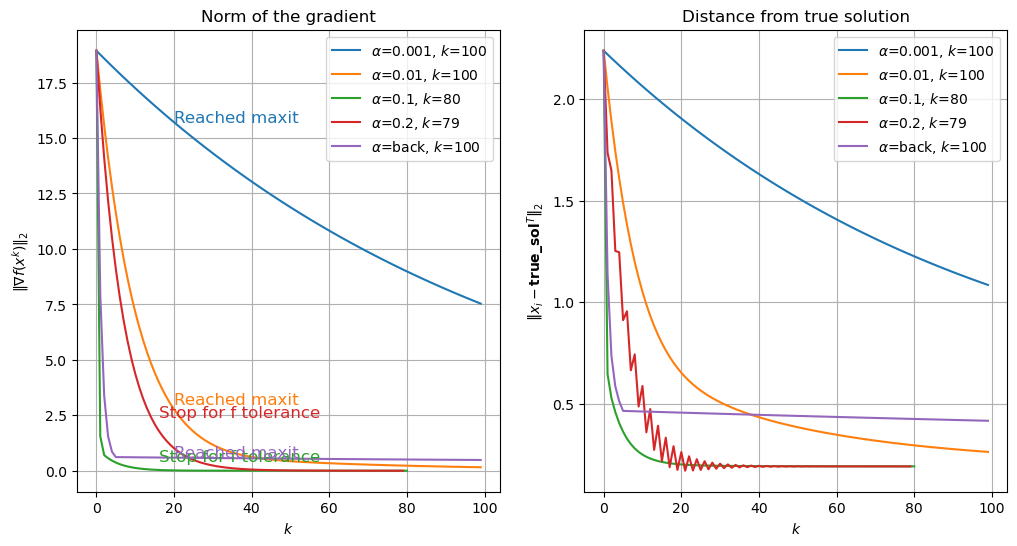

lam =  0.8


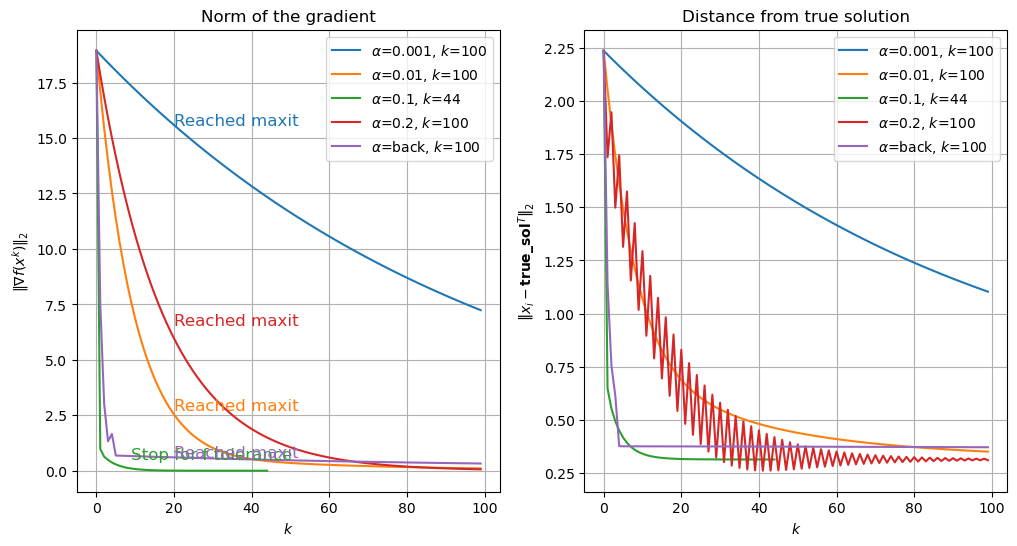

lam =  1


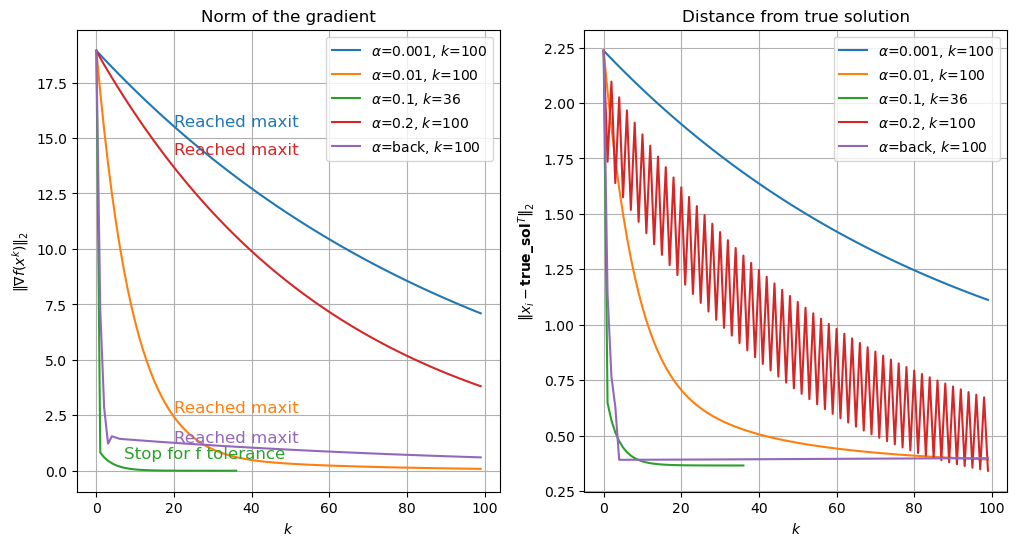

In [5]:
for l in [0,0.1,0.4,0.8,1]:
    print("lam = ", l)
    lam = l
    n = 5
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true
    x0 = np.zeros((n,))

    def f4(x,ignore):
        return (norm(A @ x - b,2) ** 2)/2 + (lam * norm(x,2)**2 / 2)

    def grad_f4(x,ignore):
        M = A @ x - b.T
        return (M @ A).T + lam*x.reshape((n,1))

    exercise_GD(f4,grad_f4,x0=x0,true_sol=x_true,dimensions=n )

The error graph for $x$ relative to the true solution $x_{true}$ shows a zig-zag pattern as the iterations progress.  
This oscillatory behavior could be caused by an improper balance between the step size $\alpha$ and the regularization parameter $\lambda$.  
A larger $\lambda$ increases the curvature of the loss function, which, combined with an insufficiently small learning rate, can lead to overshooting or oscillations during optimization.

### **Function 5**

$f : \mathbb{R} → \mathbb{R}$ such that:

$$f (x) = x^4 + x^3 − 2x^2 − 2x $$

- Where the global minima is $x^* \approx 0.92222$ 

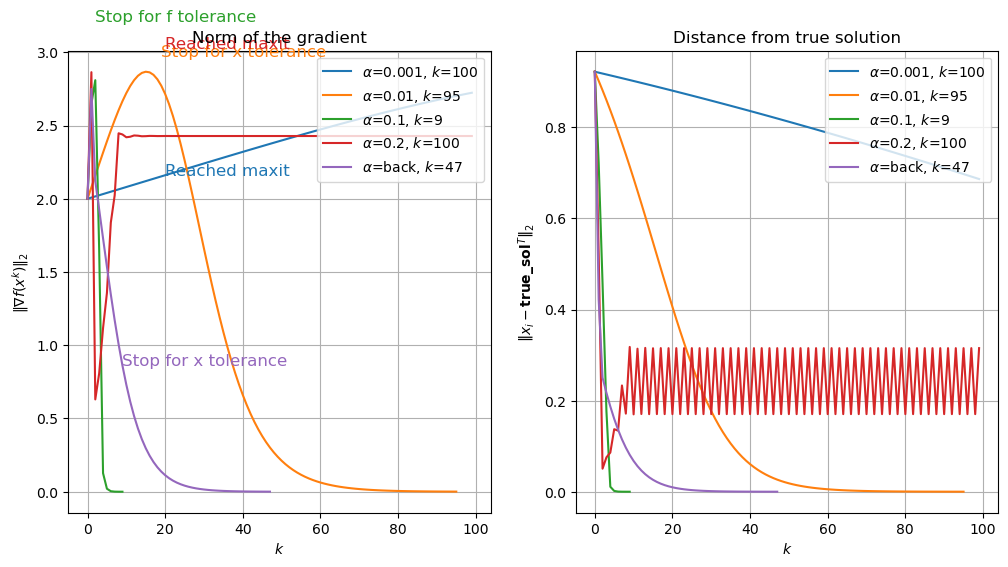

In [6]:
def f5(x,ignore):
    return x**4 + x**3 - 2*x**2 - 2*x

def grad_f5(x,ignore):
    return np.array([4*x**3 + 3*x**2 - 4*x - 2])

x0=np.array([0])
# Best value computed
true_sol = np.array([0.9222247929324218857020815]) 
exercise_GD(f5,grad_f5,x0=x0,true_sol=true_sol, dimensions=1)

For this polynomial function, it can be observed that with $\alpha=0.001$, the gradient magnitude increases steadily, and the solution seems to approach $x_{true}$ progressively.  
We can't be sure of its convergence because on the other hand, for $\alpha = 0.2$, the solution appears to "ping-pong" in a valley without making significant progress. 
This behavior is likely due to a learning rate that is too large, causing the updates to overshoot the minimum and oscillate around it rather than converging

alpha = backtracking


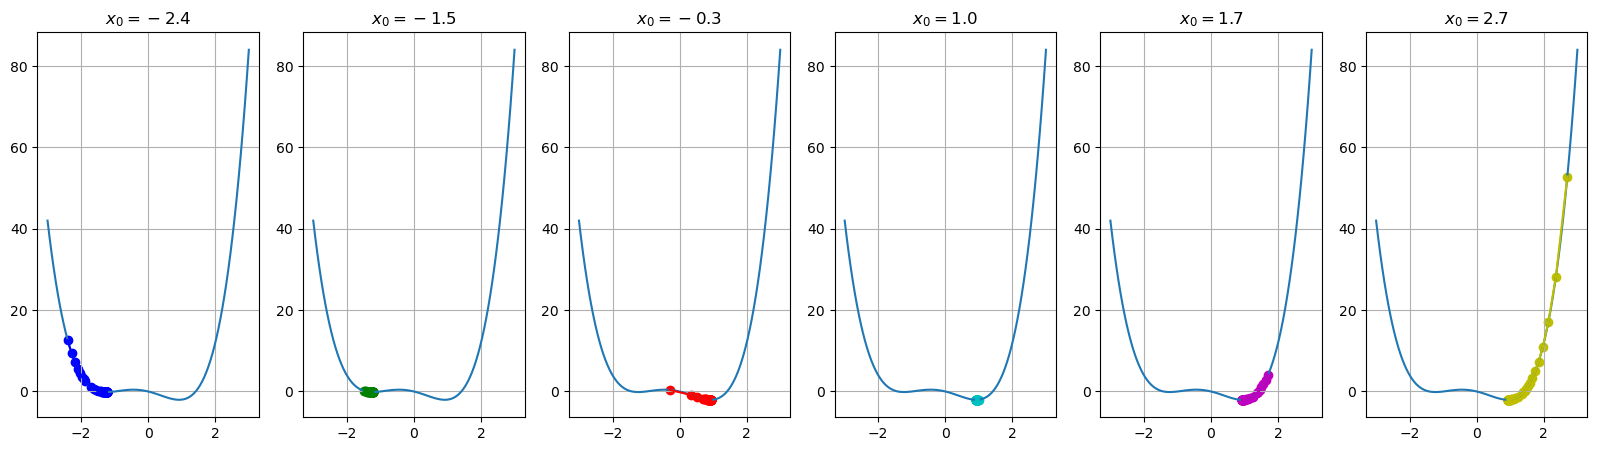

alpha =  0.001


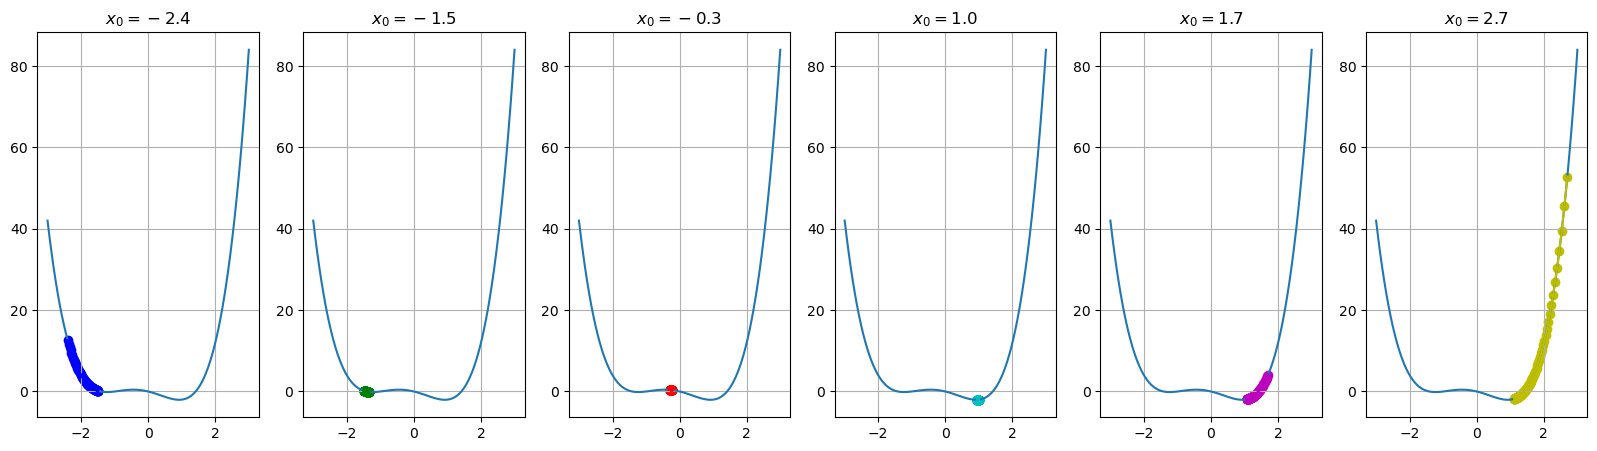

alpha =  0.01


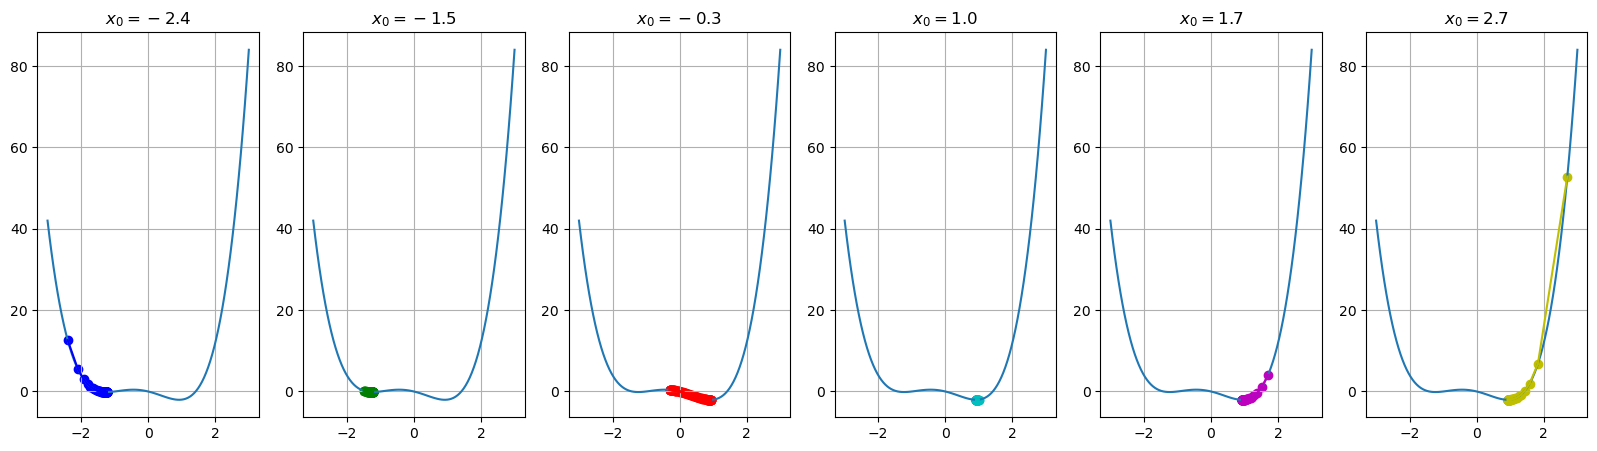

alpha =  0.1


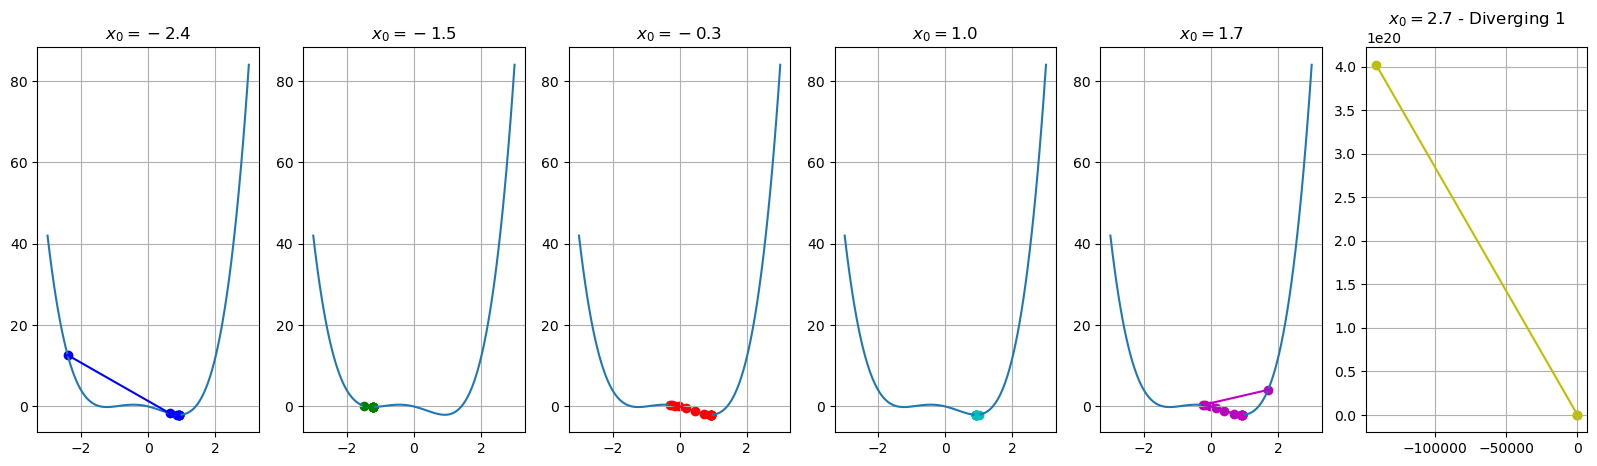

alpha =  0.2


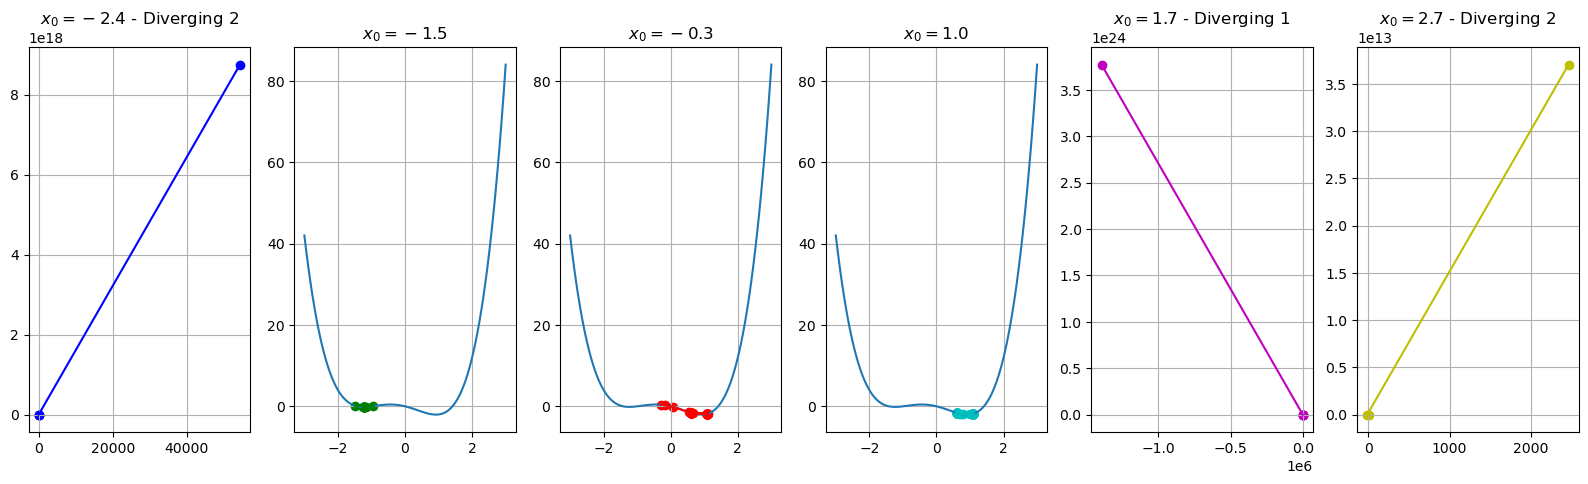

In [7]:
x0 = np.array([-2.4,-1.5,-0.3,1,1.7, 2.7])

print("alpha = backtracking")
plot_step_length(x0, f5, grad_f5)
for alpha in [0.001,0.01,0.1,0.2]:
    print("alpha = ",alpha)
    plot_step_length(x0, f5, grad_f5, alpha = alpha)

In this case is really important not only the magnitude of $\alpha$ but also the starting guess $x_0$.  
Note that we have stall for $\alpha=0.001$ and starting point $x_0 = - 0.3$.

----------------

# **Part 2 of the homework**

## Optimization via Stochastic Gradient Descent

In [9]:
ds = pd.read_csv("poly_regression_large.csv")
# Inspect the data
print(f"Shape of the data: {ds.shape}")
print("")
# Convert data into a matrix
data = np.array(ds)

X = data[:, 1]
Y = data[:, 2]

print(X.shape, Y.shape)
# ds.head()

(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, per_train=0.8)
print( Y_train.shape)

ds2 = pd.read_csv("poly_regression_small.csv")
data2 = np.array(ds2)
X2 = data2[:, 1]
Y2 = data2[:, 2]

Shape of the data: (1000, 3)

(1000,) (1000,)
Train test split = 800, 200
(800,)


In [10]:
degree_poly = 2
theta0 = np.zeros((degree_poly, ))
alpha= 0.1
batch_size=500
n_epochs=3
D = (X,Y)
theta_history, loss_history, grad_norm_history =SGD_poly(loss_mse_poly, grad_loss_mse_poly, D, degree_poly = degree_poly , theta0 = theta0, alpha = alpha, batch_size = batch_size, n_epochs = n_epochs)

D2 = (X2,Y2)
theta_history_2, loss_history_2, grad_norm_history_2 = SGD_poly(loss_mse_poly, grad_loss_mse_poly, D2, degree_poly = degree_poly ,theta0 = theta0, alpha = alpha, batch_size = batch_size, n_epochs = n_epochs)

theta_history_gd,maxit,loss_history_gd,_,grad_norm_gd,_,message = GD(loss_mse_poly, grad_loss_mse_poly, params_f = D , x0 = theta0, maxit=n_epochs, back_flag=True)
print(message)
theta_history_gd_2,maxit_2,loss_history_gd_2,_,grad_norm_gd_2,_,message = GD(loss_mse_poly, grad_loss_mse_poly, params_f = D, x0 = theta0, maxit=n_epochs, alpha=0.1)
print(message)

print("MSE for the large dataset = ", mse_error(X_test, Y_test, theta_history[-1]))
print("MSE for the small dataset = ", mse_error(X2, Y2, theta_history_2[-1]))
print("MSE for the large dataset with GD and backtraking = ", mse_error(X_test, Y_test, theta_history_gd[-1]))
print("MSE for the large dataset with GD = ", mse_error(X2, Y2, theta_history_gd_2[-1]))

Reached maxit
Reached maxit
MSE for the large dataset =  0.16909268878097217
MSE for the small dataset =  0.26755311959673495
MSE for the large dataset with GD and backtraking =  0.5294890925010697
MSE for the large dataset with GD =  0.35075094894410713


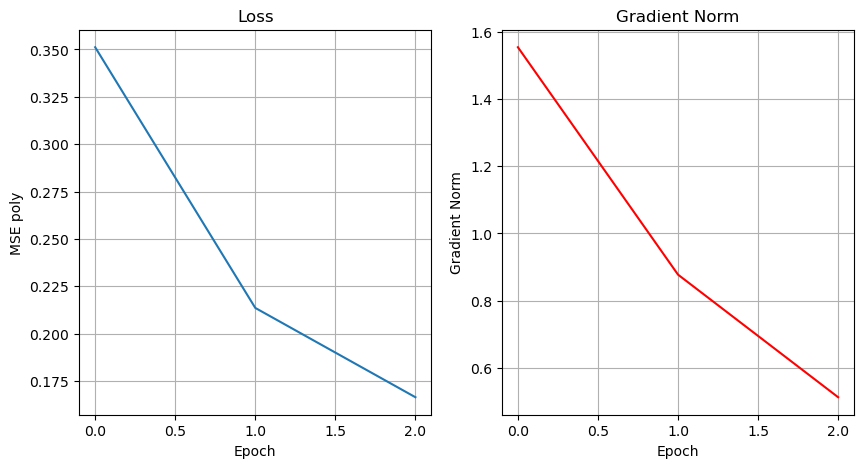

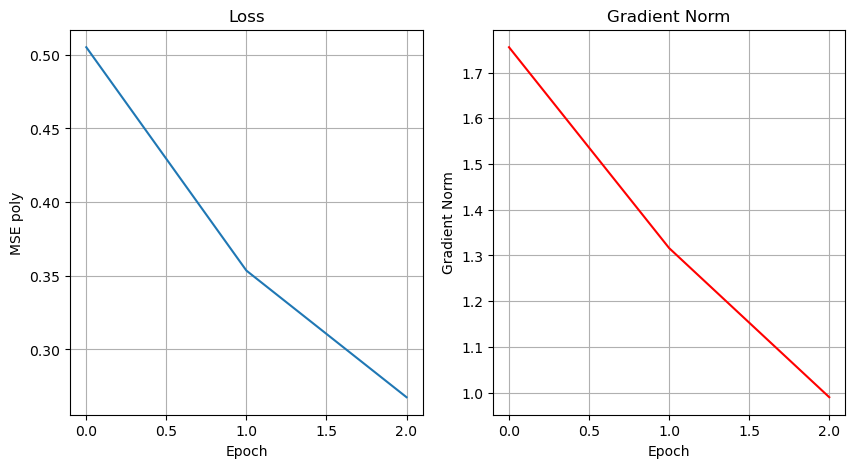

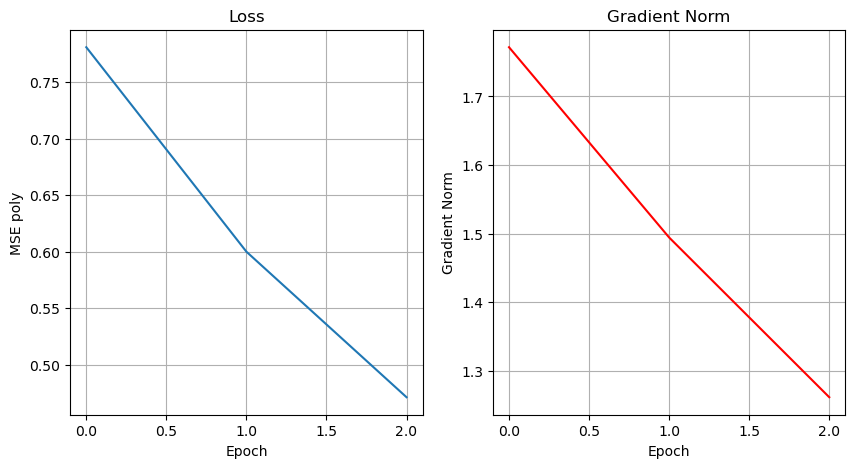

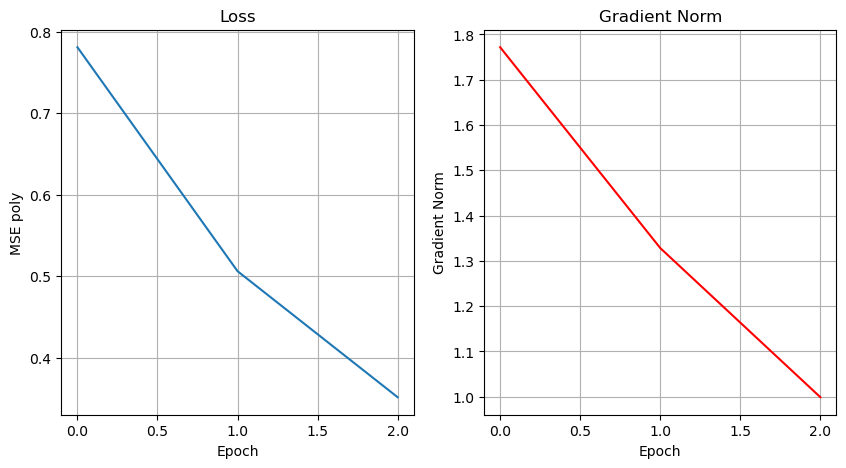

In [11]:
plot_loss(loss_history, grad_norm_history)
plot_loss(loss_history_2, grad_norm_history_2)
plot_loss(loss_history_gd, grad_norm_gd)
plot_loss(loss_history_gd_2, grad_norm_gd_2)

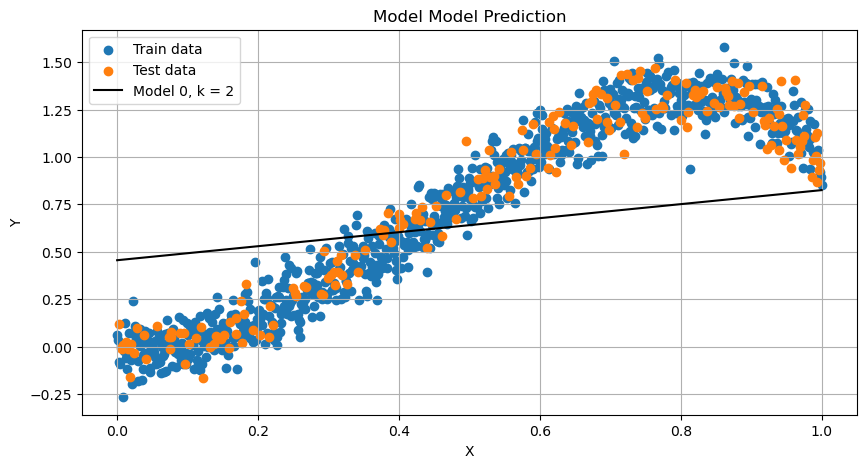

In [12]:
plot_poly_regression(X_train, Y_train, X_test, Y_test, theta_history[-1])

In [13]:
degree_poly = 5
theta0 = np.zeros((degree_poly, ))
alpha= 0.1
batch_size=300
n_epochs=5000
D = (X,Y)
theta_history, loss_history, grad_norm_history =SGD_poly(loss_mse_poly, grad_loss_mse_poly, D, degree_poly = degree_poly, theta0 = theta0, alpha = alpha, batch_size = batch_size, n_epochs = n_epochs)

D2 = (X2,Y2)
theta_history_2, loss_history_2, grad_norm_history_2 = SGD_poly(loss_mse_poly, grad_loss_mse_poly, D2, degree_poly = degree_poly, theta0 = theta0, alpha = alpha, batch_size = batch_size, n_epochs = n_epochs)

theta_history_gd,maxit,loss_history_gd,grads,err,_,message = GD(loss_mse_poly, grad_loss_mse_poly, params_f = D, x0 = theta0, maxit=n_epochs, back_flag=True)
print(message)
theta_history_gd_2,maxit_2,loss_history_gd_2,grads_2,err_2,_,message = GD(loss_mse_poly, grad_loss_mse_poly, params_f = D, x0 = theta0, maxit=n_epochs, alpha = alpha)
print(message)

print("MSE for the large dataset = ", mse_error(X_test, Y_test, theta_history[-1]))
print("MSE for the small dataset = ", mse_error(X2, Y2, theta_history_2[-1]))
print("MSE for the large dataset with GD and backtraking = ", mse_error(X_test, Y_test, theta_history_gd[-1]))
print("MSE for the large dataset with GD = ", mse_error(X2, Y2, theta_history_gd_2[-1]))

Reached maxit
Reached maxit
MSE for the large dataset =  0.009777801739520088
MSE for the small dataset =  0.014606270948785695
MSE for the large dataset with GD and backtraking =  0.0092815412346435
MSE for the large dataset with GD =  0.01622110923625013


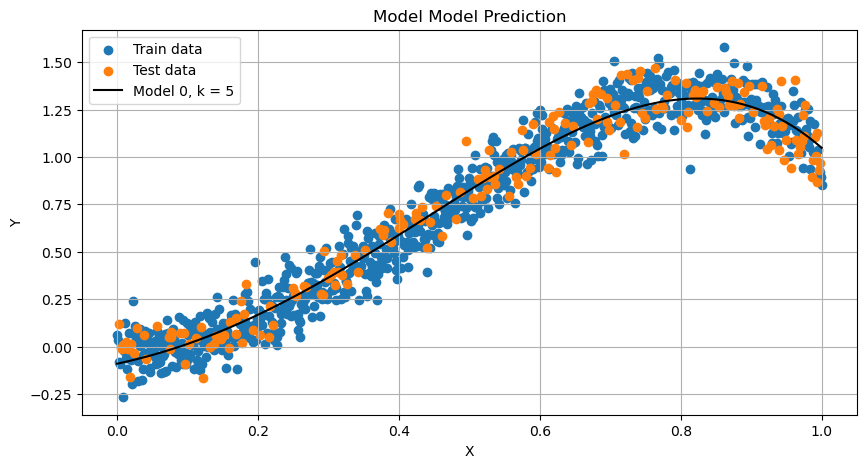

In [14]:
plot_poly_regression(X_train, Y_train, X_test, Y_test, theta_history[-1])

In [15]:
theta_true = np.array([0, 0, 4, 0, -3])
print("rel error of the theta for model 1 = ", np.linalg.norm(theta_true - theta_history[-1], 2)/np.linalg.norm(theta_true, 2))
print("rel error of the theta for model 2 = ", np.linalg.norm(theta_true - theta_history_2[-1], 2)/np.linalg.norm(theta_true, 2))
print("rel error of the theta for model 1 with GD = ", np.linalg.norm(theta_true - theta_history_gd[-1], 2)/np.linalg.norm(theta_true, 2))
print("rel error of the theta for model 2 with GD = ", np.linalg.norm(theta_true - theta_history_gd_2[-1], 2)/np.linalg.norm(theta_true, 2))

print(theta_true, theta_history[-1])

rel error of the theta for model 1 =  0.3509230386933291
rel error of the theta for model 2 =  0.5783620267273889
rel error of the theta for model 1 with GD =  0.23267623250514427
rel error of the theta for model 2 with GD =  0.6804054948063566
[ 0  0  4  0 -3] [-0.09021287  0.78940015  2.54615614  0.3251404  -2.52250103]
